In [1]:
import matplotlib.pyplot as plt

from superfv import EulerSolver, OutputLoader, plot_2d_slice
from superfv.initial_conditions import kelvin_helmholtz_2d

In [2]:
N = 64
T = 0.8
gamma = 1.4

path = "../out/kelvin-helmholtz/"
overwrite = []

configs = {
    "MUSCL-Hancock": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        p=1,
        MUSCL=True,
        MUSCL_limiter="moncen",
        SED=True,
    ),
    "ZS3": dict(
        GL=True,
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives=True,
        p=3,
        ZS=True,
        include_corners=True,
        adaptive_dt=False,
        PAD={"rho": (0, None), "P": (0, None)},
        SED=True,
    ),
    "MM3": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives=True,
        p=3,
        MOOD=True,
        cascade="muscl",
        MUSCL_limiter="moncen",
        max_MOOD_iters=1,
        limiting_vars="actives",
        NAD=True,
        include_corners=True,
        NAD_rtol=1e-2,
        NAD_atol=1e-2,
        PAD={"rho": (0, None), "P": (0, None)},
        SED=True,
    ),
}

sims = {}
for name, config in configs.items():
    if overwrite != "all":
        if name not in overwrite:
            try:
                sim = OutputLoader(path + name)
                sims[name] = sim
                continue
            except FileNotFoundError:
                pass

    print(f"Running {name}...")
    sim = EulerSolver(
        ic=kelvin_helmholtz_2d,
        gamma=gamma,
        nx=N,
        ny=N,
        cupy=True,
        **config,
    )

    try:
        if config.get("MUSCL", False):
            sim.musclhancock(T, allow_overshoot=True, path=path + name, overwrite=True)
        else:
            sim.run(T, q_max=2, allow_overshoot=True, path=path + name, overwrite=True)
        sims[name] = sim
    except Exception as e:
        print(f"Failed: {e}")
        continue

Successfully read simulation output from "../out/kelvin-helmholtz/MUSCL-Hancock"
Successfully read simulation output from "../out/kelvin-helmholtz/ZS3"
Successfully read simulation output from "../out/kelvin-helmholtz/MM3"


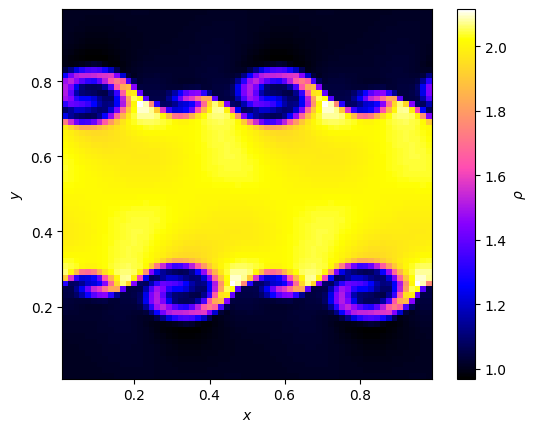

In [3]:
fig, ax = plt.subplots()

sim = sims["MUSCL-Hancock"]

im, cbar = plot_2d_slice(sim, ax, "rho", cmap="gnuplot2")

# set cbar title
cbar.set_label(r"$\rho$")